# Mask R-CNN for DeepScore

For our own dataset DeepScore

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config


%matplotlib inline 

C:\Users\johnl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import datetime
import numpy as np

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# for mask
import pathlib
from skimage.io import imread, imsave, imshow
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patchess

import skimage

# process xml file
import xml.etree.ElementTree

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

## Configurations

In [38]:
class ScoreConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "symbols"

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"
    
    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    IMAGE_MIN_SCALE = 2.0
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (28, 28)  # (height, width) of the mini-mask
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000
    
    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = 1000/IMAGES_PER_GPU
    VALIDATION_STEPS = 50/IMAGES_PER_GPU

    # Number of classes (including background)
    NUM_CLASSES = 1 + 114  # background + 114 symbols

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 512

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 512

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 512

    
config = ScoreConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        512
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                127
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               512
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

## Notebook Preferences

In [18]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [47]:
class ScoreDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_score(self, dataset_dir, subset, split):
        """Load a subset of the DeepScore dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
    
        for key, value in class_dict.items():
            self.add_class("symbol", value, key)
        # Train or validation dataset? 
        assert subset in ["train", "val"]
        img_dir = pathlib.Path(dataset_dir).glob('*/images_png/*.png')       
        img_sorted = sorted([x for x in img_dir])
        xml_dir = pathlib.Path(dataset_dir).glob('*/xml_annotations/*.xml')       
        xml_sorted = sorted([x for x in xml_dir])
        mask_dir = pathlib.Path(dataset_dir).glob('*/pix_annotations_png/*.png')
        mask_sorted = sorted([x for x in mask_dir])
        if subset == "train":
            img_sorted = img_sorted[:split]
            xml_sorted = xml_sorted[:split]
            mask_sorted = mask_sorted[:split]
        if subset == "val":
            img_sorted = img_sorted[split:]
            xml_sorted = xml_sorted[split:]
            mask_sorted = mask_sorted[split:]
        
        # add images
        for i, image_path in enumerate(img_sorted):
#             image = imread(str(image_path))
#             height, width = image.shape[:2]
            image_name = os.path.basename(image_path)
            xml_path = xml_sorted[i]
            symbols, _, height, width = get_symbol_info(xml_path)
            
            mask_path = str(mask_sorted[i])
            
            self.add_image(
                "symbol",
                image_id=image_name,
                path=image_path,
                width=width, height=height,
                symbols=symbols, mask_path=mask_path)
        

    def image_reference(self, image_id):
        """Return the score data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "symbol":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """        
        image_info = self.image_info[image_id]
        if image_info["source"] != "symbol":
            return super(self.__class__, self).load_mask(image_id)

        # image_id == xml_id
        symbols = image_info['symbols']
        mask = imread(image_info['mask_path'])
        masks = np.zeros([image_info['height'], image_info['width'], len(symbols)], dtype=np.uint8)
        for i, symbol in enumerate(symbols):
            # coords are row, col, so we should put (y, x), instead of (x, y)
            xmin, xmax, ymin, ymax = symbol[1], symbol[2], symbol[3], symbol[4]
            masks[ymin:ymax+1, xmin:xmax+1, i] = mask[ymin:ymax+1, xmin:xmax+1]
        
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in symbols])
            
        
        return masks.astype(np.bool), class_ids.astype(np.int32)

In [48]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = ScoreDataset()
    dataset_train.load_score(dataset_dir, "train", split)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = ScoreDataset()
    dataset_val.load_score(dataset_dir, "val", split)
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

## Load Data

In [43]:
# Glob the training data and load a single image path
img_paths = pathlib.Path('../../').glob('*/images_png/*.png')
img_sorted = sorted([x for x in img_paths])

# mask and xml files
mask_paths = pathlib.Path('../../').glob('*/pix_annotations_png/*.png')
mask_sorted = sorted([x for x in mask_paths])

xml_paths = pathlib.Path('../../').glob('*/xml_annotations/*.xml')
xml_sorted = sorted([x for x in xml_paths])

# check the image, mask and xml path names are in the same order
rand_img = 1000
im_path = img_sorted[rand_img]
mask_path = mask_sorted[rand_img]
xml_path = xml_sorted[rand_img]
num_samples = len(img_sorted)
print(im_path)
print(len(img_sorted))
print(mask_path)
print(xml_path)
im = imread(str(im_path))
mask = imread(str(mask_path))
root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
size = root.findall('size')
width = float(size[0][0].text)
height = float(size[0][1].text)

..\..\Mask_RCNN\images_png\lg-127568901-aug-beethoven--page-71.png
10000
..\..\Mask_RCNN\pix_annotations_png\lg-127568901-aug-beethoven--page-71.png
..\..\Mask_RCNN\xml_annotations\lg-127568901-aug-beethoven--page-71.xml


In [22]:
# get the information of all symbols in one image
def get_symbol_info(xml_path):
    root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
    size = root.findall('size')
    width = float(size[0][0].text)
    height = float(size[0][1].text)

    symbols = []
    symbol_names = set() # use a set to store unique symbol names
    rectangles = []

    # get the bounding box for each object, multiply with its width and height to get the real pixel coords
    for symbol in root.findall('object'):
        name = symbol.find('name').text
        xmin = round(float(symbol.find('bndbox')[0].text)*width)
        xmax = round(float(symbol.find('bndbox')[1].text)*width)
        ymin = round(float(symbol.find('bndbox')[2].text)*height)
        ymax = round(float(symbol.find('bndbox')[3].text)*height)

#         current_rectangle = name, (xmin, ymin), xmax - xmin, ymax - ymin
        current_symbol = name, xmin, xmax, ymin, ymax
#         rectangles.append(current_rectangle)
        symbols.append(current_symbol)
        symbol_names.add(name)
    return symbols, symbol_names, int(height), int(width)

In [24]:
# uncomment the whole cell if you want to regenerate symbol set
# class_dict = {}
# symbol_type = set()
# # form a universal symbol set fot the whole dataset, this can take 2 ~ 3 min
# for x in xml_sorted:
#     _, symbol_names,_ = get_symbol_info(x)
#     symbol_type = symbol_type.union(symbol_names)

# # save the symbol_type set for convenience# save t 
# np.save('symbol_type.npy', symbol_type) 
# # Load the dictionary
# symbol_type = np.load('symbol_type.npy').item()
# print('Total num of symbols in the dictionary: %d' % (len(symbol_type)))
# i = 0
# for item in symbol_type:
#     class_dict[item] = i
#     i += 1
# print(class_dict['fClef'])
# save the class dictionary for futre use so that the integer class label does not change every time
np.save('class_dict.npy', class_dict)

In [26]:
# uncomment this cell if you want to load previous symbol dict
class_dict = np.load('class_dict.npy').item()
print('Total number of symbols in the whole dataset:', len(class_dict))
print('The integer value for fClef is:', class_dict['fClef'])

Total number of symbols in the whole dataset: 114
The integer value for fClef is: 85


# Create Dataset

In [27]:
# load dataset
# the directory where deepscore folder is in
dataset_dir = '../../'
# The former split number of data used as training data
# The latter num_samples - split number of data used as validation data
split = 8000

In [50]:
# the dataset is very large, can take 1~3 minutes
# Training dataset
dataset_train = ScoreDataset()
dataset_train.load_score(dataset_dir, "train", split)
dataset_train.prepare()

# Validation dataset
dataset_val = ScoreDataset()
dataset_val.load_score(dataset_dir, "val", split)
dataset_val.prepare()

In [44]:
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 8000
Class Count: 115
  0. BG                                                
  1. cClefAlto                                         
  2. accidentalFlat                                    
  3. rest32nd                                          
  4. repeatDot                                         
  5. flag128thDown                                     
  6. timeSig1                                          
  7. keyboardPedalUp                                   
  8. dynamicPPPP                                       
  9. rest8th                                           
 10. flag16thDown                                      
 11. ornamentMordent                                   
 12. gClefChange                                       
 13. graceNoteAppoggiaturaStemDown                     
 14. cClefAltoChange                                   
 15. timeSig2                                          
 16. dynamicMF                                         
 17. dynamicF

In [29]:
# print("Image Count: {}".format(len(dataset_train.image_ids)))
# print("Class Count: {}".format(dataset_train.num_classes))
# for i, info in enumerate(dataset_train.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

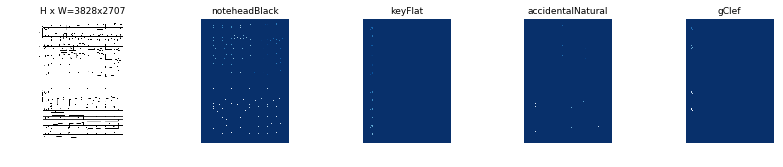

In [30]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    print('There are %d symbols in the score' %(mask.shape[2]))

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  5095 ..\..\Mask_RCNN\images_png\lg-320597050217018391-aug-lilyjazz--page-7.png
image                    shape: (3828, 2707, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (3828, 2707, 200)     min:    0.00000  max:    1.00000  bool
class_ids                shape: (200,)                min:   33.00000  max:  112.00000  int32
bbox                     shape: (200, 4)              min:    0.00000  max: 2546.00000  int32


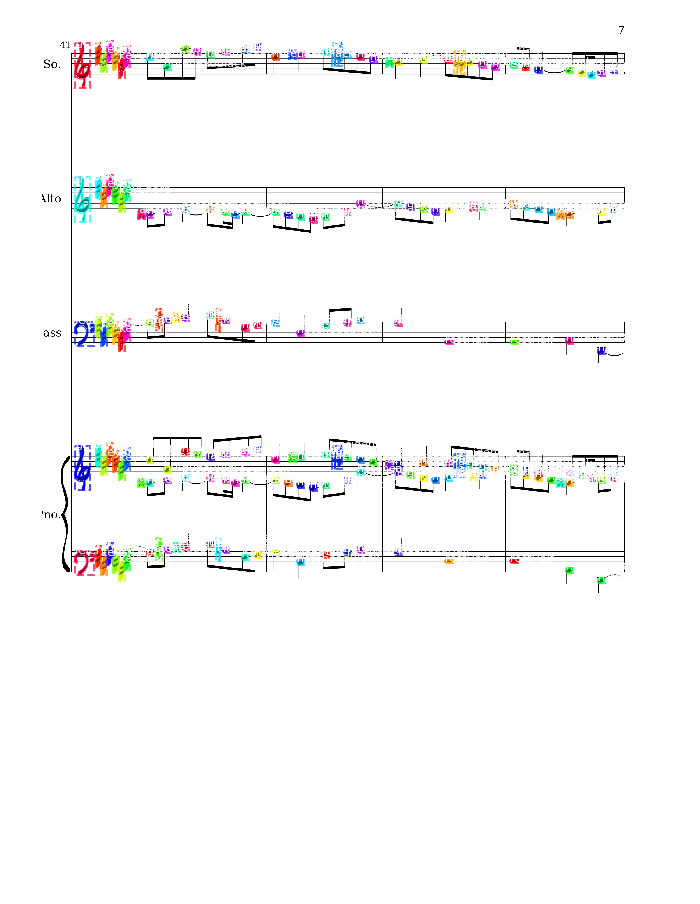

In [51]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [39]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [40]:
# initialize weights from pretrained model instead of from scratch
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [41]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Downloads\DeepScores_archive0\Mask_RCNN\logs\symbols20180602T1504\mask_rcnn_symbols_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

C:\Users\johnl\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


ERROR:root:Error processing image {'id': 'lg-1616506508031197-aug-gutenberg1939--page-1.png', 'source': 'symbol', 'path': WindowsPath('../../Mask_RCNN/images_png/lg-1616506508031197-aug-gutenberg1939--page-1.png'), 'width': 2707, 'height': 3828, 'symbols': [('noteheadBlack', 1913, 1936, 632, 655), ('rest16th', 1912, 1938, 480, 538), ('augmentationDot', 1957, 1967, 438, 447), ('noteheadBlack', 2030, 2053, 454, 476), ('noteheadBlack', 1976, 1999, 442, 465), ('restQuarter', 1661, 1682, 437, 496), ('noteheadBlack', 1662, 1686, 408, 431), ('noteheadBlack', 1608, 1632, 397, 419), ('noteheadBlack', 1771, 1794, 431, 454), ('noteheadBlack', 1825, 1848, 442, 465), ('noteheadHalf', 1913, 1947, 430, 454), ('noteheadBlack', 1716, 1740, 419, 442), ('noteheadBlack', 2523, 2546, 643, 666), ('noteheadBlack', 2463, 2486, 666, 689), ('noteheadBlack', 2192, 2216, 632, 655), ('noteheadBlack', 2138, 2162, 632, 655), ('noteheadHalf', 2138, 2173, 453, 477), ('noteheadBlack', 2084, 2107, 465, 488), ('noteheadB

ERROR:root:Error processing image {'id': 'lg-398525122645378443-aug-beethoven--page-57.png', 'source': 'symbol', 'path': WindowsPath('../../Mask_RCNN/images_png/lg-398525122645378443-aug-beethoven--page-57.png'), 'width': 2707, 'height': 3828, 'symbols': [('noteheadBlack', 2141, 2170, 2834, 2859), ('noteheadBlack', 2141, 2170, 2868, 2893), ('noteheadBlack', 2141, 2170, 2914, 2939), ('rest8th', 2114, 2142, 2424, 2467), ('rest64th', 2141, 2185, 3097, 3204), ('noteheadBlack', 2191, 2220, 2868, 2893), ('noteheadBlack', 2191, 2220, 2834, 2859), ('flag8thUp', 2045, 2069, 159, 225), ('noteheadBlack', 2044, 2073, 2868, 2893), ('flag16thDown', 2019, 2045, 3191, 3258), ('flag16thUp', 2045, 2070, 3105, 3183), ('noteheadBlack', 2044, 2073, 698, 723), ('noteheadBlack', 2044, 2073, 652, 677), ('noteheadBlack', 2072, 2101, 641, 666), ('noteheadBlack', 2044, 2073, 595, 620), ('noteheadBlack', 2044, 2073, 2914, 2939), ('noteheadBlack', 2088, 2117, 2914, 2939), ('noteheadBlack', 2088, 2117, 2868, 2893),

ERROR:root:Error processing image {'id': 'lg-148271825-aug-beethoven--page-21.png', 'source': 'symbol', 'path': WindowsPath('../../Mask_RCNN/images_png/lg-148271825-aug-beethoven--page-21.png'), 'width': 2707, 'height': 3828, 'symbols': [('flag8thDown', 1868, 1891, 1871, 1938), ('flag8thDown', 1754, 1776, 1826, 1892), ('noteheadBlack', 1867, 1896, 961, 986), ('noteheadBlack', 1867, 1896, 1823, 1849), ('noteheadBlack', 1867, 1896, 1846, 1871), ('articStaccatoAbove', 1877, 1886, 1490, 1499), ('noteheadBlack', 1867, 1896, 1504, 1529), ('noteheadBlack', 1867, 1896, 1527, 1552), ('noteheadBlack', 1867, 1896, 1549, 1575), ('noteheadBlack', 1867, 1896, 1189, 1214), ('noteheadBlack', 1867, 1896, 1269, 1294), ('articStaccatoBelow', 1877, 1886, 990, 999), ('noteheadBlack', 1867, 1896, 915, 940), ('noteheadBlack', 1867, 1896, 938, 963), ('noteheadBlack', 1867, 1896, 1800, 1826), ('noteheadBlack', 1867, 1896, 566, 591), ('noteheadBlack', 1867, 1896, 171, 196), ('flag8thUp', 1780, 1804, 3250, 3315)

ResourceExhaustedError: OOM when allocating tensor with shape[512,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: mrcnn_mask_deconv_1/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](mrcnn_mask_deconv_1/conv2d_transpose-0-VecPermuteNHWCToNCHW-LayoutOptimizer/_5653, mrcnn_mask_deconv_1/kernel/read, mrcnn_mask_deconv_1/conv2d_transpose-2-TransposeNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: mul_103/_5937 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_8539_mul_103", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'mrcnn_mask_deconv_1/conv2d_transpose', defined at:
  File "C:\Users\johnl\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\johnl\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\johnl\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\johnl\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\johnl\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\johnl\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\johnl\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\johnl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-7928c4edfc77>", line 3, in <module>
    model_dir=MODEL_DIR)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\model.py", line 1823, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\model.py", line 1985, in build
    train_bn=config.TRAIN_BN)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\model.py", line 996, in build_fpn_mask_graph
    name="mrcnn_mask_deconv")(x)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\keras\layers\wrappers.py", line 213, in call
    y = self.layer.call(inputs, **kwargs)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 781, in call
    data_format=self.data_format)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3394, in conv2d_transpose
    data_format=tf_data_format)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1254, in conv2d_transpose
    name=name)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1340, in conv2d_backprop_input
    dilations=dilations, name=name)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\johnl\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[512,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: mrcnn_mask_deconv_1/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](mrcnn_mask_deconv_1/conv2d_transpose-0-VecPermuteNHWCToNCHW-LayoutOptimizer/_5653, mrcnn_mask_deconv_1/kernel/read, mrcnn_mask_deconv_1/conv2d_transpose-2-TransposeNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: mul_103/_5937 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_8539_mul_103", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))